In [1]:
# Standard libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import json
from PIL import Image
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm

from DiffJPEG import DiffJPEG
from layers import gumbel_softmax
from helpers import create_default_qtables, return_class_name, return_class_accuracy, visualize

In [2]:
resnet = torchvision.models.resnet50(pretrained=False) 
#Just use pretrained = True if you can download the weights
resnet.load_state_dict(torch.load('../weights/resnet50.pth')) 
resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False
print()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
f = open("class_lists/imagenet_class_index.json")
id_classname_json = json.load(f)
preprocess = transforms.Compose([
                            # transforms.CenterCrop((crop_size[1],crop_size[0])),
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            ])
image = preprocess(Image.open("sample_imgs/panda.jpg"))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
norm = transforms.Normalize(mean=mean, std=std)

3.333333333333333


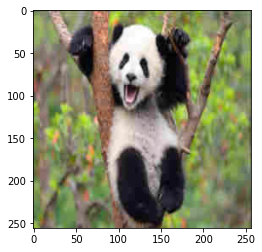

In [7]:
y_table, c_table = create_default_qtables()
JPEGCompress = DiffJPEG(image.shape[1], image.shape[2], differentiable=True, quality=15)
compressed_image = JPEGCompress(image.unsqueeze(0), y_table, c_table)[0]
plt.imshow(transforms.ToPILImage()(compressed_image))

In [8]:
with torch.no_grad():
    predictions = resnet(norm(image).unsqueeze(0))
    (target_class, target_dim) = return_class_name(id_classname_json, predictions)
    print(target_class)
    acc_of_original = return_class_accuracy(predictions, target_dim)
    
    predictions = resnet(norm(compressed_image).unsqueeze(0))
    acc_of_compressed = return_class_accuracy(predictions, target_dim)
    print(acc_of_original, acc_of_compressed)
    # predictied_class = return_class_name(predictions)[0]

giant_panda
65.0 52.0


In [9]:
train_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train2", transform = preprocess)
train_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
train_dataset.samples = train_dataset.make_dataset(train_dataset.root, 
                                                   train_dataset.class_to_idx, 
                                                   train_dataset.extensions, 
                                                   None)

val_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train2", transform = preprocess)
val_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
val_dataset.samples = val_dataset.make_dataset(val_dataset.root, 
                                               val_dataset.class_to_idx, 
                                               val_dataset.extensions, 
                                               None)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 256)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=16)

In [10]:
# pred = resnet(dataset[i][0].unsqueeze(0))
# idx = 9000
# print(return_class_name(resnet(dataset[idx][0].expand(3,-1,-1).unsqueeze(0))), dataset[idx][1])
# [print(return_class_name(resnet(i[0].expand(3,-1,-1).unsqueeze(0))), j) for i, j in dataset]

In [11]:
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor))
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor))

In [12]:
y_table.shape

torch.Size([8, 8])

In [13]:
gumbel_softmax(y_table_1hot*10, 0.1, True).argmax(dim=2)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72],
        [ 11,  12,  13,  17,  22,  35,  64,  92],
        [ 10,  14,  16,  22,  37,  55,  78,  95],
        [ 16,  19,  24,  29,  56,  64,  87,  98],
        [ 24,  26,  40,  51,  68,  81, 103, 112],
        [ 40,  58,  57,  87, 109, 104, 121, 100],
        [ 51,  60,  69,  80, 103, 113, 120, 103],
        [ 61,  55,  56,  62,  77,  92, 101,  99]])

## Perturbing the Q-Tables to get better results

In [14]:
y_table, c_table = create_default_qtables()
# y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
# c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), num_classes=255).type(torch.FloatTensor)*10
c_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), num_classes=255).type(torch.FloatTensor)*10

y_table_1hot.requires_grad = True
c_table_1hot.requires_grad = True

optimizer = torch.optim.NAdam([
    y_table_1hot, 
    c_table_1hot
], lr=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma = 0.9)

ones_table = torch.ones((8,8))
ones_table.requires_grad = False

categorical_values_table = torch.arange(255).reshape(1,-1) + 1
categorical_values_table.requires_grad = False

# print(y_table.requires_grad)

# epsilon = 0.0081 #can try out lesser values as well
# epsilon = 1.0
loss = torch.nn.MSELoss()
qloss = torch.nn.MSELoss(reduction='mean')

best_y_1hot = deepcopy(y_table_1hot)

best_y_table = deepcopy(y_table)
best_c_table = deepcopy(c_table)
best_val_loss = np.inf

ori_train_acc = 0.0

initial_temperature = 0.3
temperature_anneal_rate = 0.05
alpha = torch.tensor((1/10000000))
alpha.requires_grad=True

for epoch in range(1000):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0
    
    temperature = max(0.001, initial_temperature*np.exp(-temperature_anneal_rate*epoch))
    
    for (image, labels) in tqdm(train_loader):
        with torch.no_grad():
            ori_logits = resnet(norm(image))
            (target_class, target_dim) = return_class_name(id_classname_json, ori_logits[-1].unsqueeze(0))
            original_acc = return_class_accuracy(ori_logits[-1].unsqueeze(0), target_dim)
            if epoch == 0:
                ori_train_acc = ori_train_acc + (ori_logits.argmax(dim=1) == labels).sum()
                
        
        # y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        # c_table = gumbel_softmax(c_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        
#         y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255), dim=2) * categorical_values_table
#         c_table = torch.nn.functional.softmax(c_table_1hot.view(1, -1, 255), dim=2) * categorical_values_table
        
#         y_table = y_table.sum(dim=2).reshape(8,8)
#         c_table = c_table.sum(dim=2).reshape(8,8)

        y_table
        
        compressed_image = JPEGCompress(image, y_table, c_table)
        data = norm(compressed_image)
        logits = resnet(data)
        pred = logits.argmax(dim=1)
        
        loss_minimize = loss(logits, ori_logits) #we try to minimize this loss
        loss_maximize = (- qloss(y_table, ones_table) - qloss(c_table, ones_table))
        total_loss = (1-alpha)*loss_minimize + (alpha)* loss_maximize #total loss to be optimized

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # print((y_table_1hot == best_y_1hot).all())
        
        running_train_loss = running_train_loss + total_loss.detach().cpu()
        running_train_acc = running_train_acc + (pred == labels).sum()
    lr_scheduler.step()
            
    if running_train_loss/len(train_dataset) < best_val_loss:
        best_y_table = y_table
        best_c_table = c_table
        best_val_loss = running_val_loss/len(train_dataset)
        torch.save({"y_table" : y_table,
                   "c_table" : c_table,
                    "optimizer" : optimizer.state_dict(),
                   }, "best_ckpt.tar")
    
    if epoch == 0 :
        ori_train_acc = ori_train_acc / len(train_dataset)
    print("epoch {0}, training_loss: {1}, training_acc: {2}, val_loss: {3}, val_acc: {4}, ori_train_acc: {5}, logit loss: {6}, q table loss: {7}".format(
        epoch, running_train_loss/len(train_dataset), running_train_acc/len(train_dataset),
        running_val_loss/len(train_dataset), running_val_acc/len(train_dataset), ori_train_acc,
        loss_minimize, loss_maximize
    ))
        

100%|██████████| 1/1 [00:26<00:00, 26.51s/it]


epoch 0, training_loss: 0.018445858731865883, training_acc: 0.6857143044471741, val_loss: 0.0, val_acc: 0.0, ori_train_acc: 0.8285714387893677, logit loss: 1.2924443483352661, q table loss: -12340.140625


  0%|          | 0/1 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# Calculate performance with default Q-Tables

y_table, c_table = create_default_qtables()
# y_table = torch.ones((8,8))
# c_table = torch.ones((8,8))
train_acc = 0
for (image, labels) in tqdm(train_loader):
    with torch.no_grad():
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels).sum()

print(train_acc/len(train_dataset))
    
        

100%|██████████| 1/1 [00:07<00:00,  8.00s/it]

tensor(0.8286)


In [23]:
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)/0.01, dim=2) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table.type(torch.LongTensor)

tensor([[2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2]])

In [123]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)*10.0, dim=2) * categorical_values_table
        
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[ 17.2818,  13.3276,  15.3047,  15.3047,  19.2589,  25.1903,  49.9041,
          72.6409],
        [ 12.3391,  13.3276,  14.3162,  18.2704,  23.2132,  36.0644,  64.7325,
          92.4120],
        [ 11.3505,  15.3047,  17.2818,  23.2132,  38.0415,  55.8355,  78.5722,
          95.3777],
        [ 17.2818,  20.2475,  25.1903,  30.1330,  56.8240,  64.7325,  87.4692,
          98.3433],
        [ 25.1903,  27.1674,  41.0071,  51.8812,  68.6867,  81.5379, 103.2861,
         112.1831],
        [ 41.0071,  58.8011,  57.8126,  87.4692, 109.2174, 104.2747, 121.0801,
         100.3204],
        [ 51.8812,  60.7782,  69.6752,  80.5493, 103.2861, 113.1716, 120.0915,
         103.2861],
        [ 61.7668,  55.8355,  56.8240,  62.7553,  77.5836,  92.4120, 101.3090,
          99.3319]])

In [88]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*10.0, temperature, True).argmax(dim=2)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72,  11,  12,  13,  17,  22,  35,
          64,  92,  10,  14,  16,  22,  37,  55,  78,  95,  16,  19,  24,  29,
          56,  64,  87,  98,  24,  26,  40,  51,  68,  81, 103, 112,  40,  58,
          57,  87, 109, 104, 121, 100,  51,  60,  69,  80, 103, 113, 120, 103,
          61,  55,  56,  62,  77,  92, 101,  99]])

In [24]:
y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), 0.01, True) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<ReshapeAliasBackward0>)

In [29]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5

In [29]:
y_table_1hot.view(-1,255)

torch.Size([64, 255])

In [36]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*5, 0.1, True).argmax(dim=2).reshape(8,8)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72],
        [ 11,  12,  13,  17,  22,  35,  64,  92],
        [ 10,  14,  16,  22,  37,  55,  78,  95],
        [ 16,  19,  24,  29,  56,  64,  87,  98],
        [ 24,  26,  40,  51,  68,  81, 103, 112],
        [ 40,  58,  57,  87, 109, 104, 121, 100],
        [ 51,  60,  69,  80, 103, 113, 120, 103],
        [ 61,  55,  56,  62,  77,  92, 101,  99]])

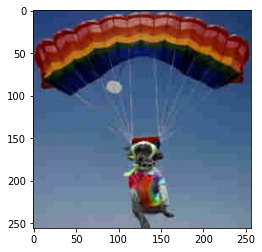

In [38]:
compressed = JPEGCompress(image, torch.round(y_table), torch.round(c_table))[1]
plt.imshow(transforms.ToPILImage()(compressed))

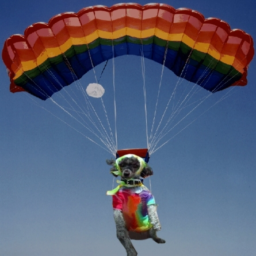

In [36]:
transforms.ToPILImage()(image[1])